# 4) Temizleme (tokenizasyon/stopword/lemmasyon opsiyonel)

İngilizce için basit temizlik genelde yeterli. Aşırı agresif temizlik **anlam** kaybettirebilir.


In [1]:
import pandas as pd
import numpy as np
import re
import sys
sys.path.append('..')

from utils import basic_clean


In [2]:
# Veriyi yükle
df = pd.read_csv("../data/cleaned_data.csv")

# Temizleme uygula
df['text_clean'] = df['text'].apply(basic_clean)

print(df.head(3))


                                                text     label  \
0  connection with icon icon dear please setup ic...  Hardware   
1  work experience user work experience user hi w...    Access   
2  requesting for meeting requesting meeting hi p...  Hardware   

                                          text_clean  
0  connection with icon icon dear please setup ic...  
1  work experience user work experience user hi w...  
2  requesting for meeting requesting meeting hi p...  


# 5) Word2Vec Eğit (gensim) ve Embedding Matrisi Hazırla


In [ ]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore


In [4]:
# Train/val/test split (aynı şekilde)
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    df["text_clean"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print(len(X_train), len(X_val), len(X_test))


38269 4784 4784


## 5.1 Tokenizer


In [5]:
MAX_VOCAB = 40000

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_val   = tokenizer.texts_to_sequences(X_val)
seq_test  = tokenizer.texts_to_sequences(X_test)

print(f"Vocabulary size: {len(tokenizer.word_index)}")


Vocabulary size: 11661


## Padding


In [6]:
MAX_LEN = 80  # ticket metinleri için pratik başlangıç

Xtr = pad_sequences(seq_train, maxlen=MAX_LEN, padding="post", truncating="post")
Xv  = pad_sequences(seq_val,   maxlen=MAX_LEN, padding="post", truncating="post")
Xt  = pad_sequences(seq_test,  maxlen=MAX_LEN, padding="post", truncating="post")

print(f"Train shape: {Xtr.shape}")


Train shape: (38269, 80)


## 5.2 Word2Vec (corpus: train)


In [7]:
sentences = [ [w for w in t.split()] for t in X_train.tolist() ]

w2v = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=2, workers=4, sg=1, epochs=10)

print(f"Word2Vec model trained with {len(w2v.wv)} words")


Word2Vec model trained with 8996 words


## 5.3 Embedding Matrisi


In [8]:
word_index = tokenizer.word_index
vocab_size = min(MAX_VOCAB, len(word_index)+1)
emb_dim = w2v.vector_size

embedding_matrix = np.random.normal(0, 0.6, (vocab_size, emb_dim)).astype(np.float32)

for word, idx in word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")


Embedding matrix shape: (11662, 200)


# 6) LSTM Modeli (Keras)


In [9]:
import tensorflow as tf  # type: ignore
from tensorflow.keras import layers, models  # type: ignore
from sklearn.preprocessing import LabelEncoder


In [10]:
# Label encoding
le = LabelEncoder()
ytr = le.fit_transform(y_train)
yv  = le.transform(y_val)
yt  = le.transform(y_test)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")


Number of classes: 8


## Model Mimarisi


In [11]:
inp = layers.Input(shape=(MAX_LEN,))

emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim,
                       weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)(inp)

x = layers.SpatialDropout1D(0.2)(emb)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inp, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


c:\Users\ertug\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 200)        │     2,332,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 80, 200)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 256)        │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,671,352 (10.19 MB)

 Trainable params: 338,952 (1.29 MB)

 Non-trainable params: 2,332,400 (8.90 MB)

## Class Weight (dengesiz sınıflar için)


In [12]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(ytr)
class_weights_arr = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
cw = { int(le.transform([k])[0]): float(v) for k,v in zip(le.classes_, class_weights_arr) if k in le.classes_ }

print(f"Class weights computed: {len(cw)} classes")


Class weights computed: 8 classes


## Eğitim


In [13]:
early = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")

hist = model.fit(
    Xtr, ytr,
    validation_data=(Xv, yv),
    epochs=15, batch_size=64,
    callbacks=[early],
    class_weight=cw if len(cw)>0 else None,
    verbose=1
)


Epoch 1/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 63s 100ms/step - accuracy: 0.6658 - loss: 0.7868 - val_accuracy: 0.8012 - val_loss: 0.5892
Epoch 2/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.7761 - loss: 0.5026 - val_accuracy: 0.8186 - val_loss: 0.5264
Epoch 3/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.8021 - loss: 0.4383 - val_accuracy: 0.8202 - val_loss: 0.5164
Epoch 4/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.8172 - loss: 0.3988 - val_accuracy: 0.8315 - val_loss: 0.4932
Epoch 5/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 96ms/step - accuracy: 0.8275 - loss: 0.3660 - val_accuracy: 0.8361 - val_loss: 0.4664
Epoch 6/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.8385 - loss: 0.3455 - val_accuracy: 0.8418 - val_loss: 0.4423
Epoch 7/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.8465 - loss: 0.3222 - val_accuracy: 0.8466 - val_loss: 0.4402
Epoch 8/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.8523 - loss: 0.3033 -

## Değerlendirme


In [14]:
from sklearn.metrics import classification_report, accuracy_score

# Validation seti
pred_val = model.predict(Xv).argmax(axis=1)
print("\n=== VALIDATION SONUÇLARI ===")
print(f"Accuracy: {accuracy_score(yv, pred_val):.4f}")
print(classification_report(yv, pred_val, target_names=le.classes_, zero_division=0))


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step

=== VALIDATION SONUÇLARI ===
Accuracy: 0.8694
                       precision    recall  f1-score   support

               Access       0.88      0.92      0.90       712
Administrative rights       0.72      0.82      0.77       176
           HR Support       0.88      0.91      0.90      1092
             Hardware       0.91      0.79      0.84      1362
     Internal Project       0.83      0.92      0.87       212
        Miscellaneous       0.80      0.88      0.84       706
             Purchase       0.95      0.89      0.92       246
              Storage       0.90      0.90      0.90       278

             accuracy                           0.87      4784
            macro avg       0.86      0.88      0.87      4784
         weighted avg       0.87      0.87      0.87      4784



In [15]:
# Test seti
pred_test = model.predict(Xt).argmax(axis=1)
print("\n=== TEST SONUÇLARI ===")
print(f"Accuracy: {accuracy_score(yt, pred_test):.4f}")
print(classification_report(yt, pred_test, target_names=le.classes_, zero_division=0))


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step

=== TEST SONUÇLARI ===
Accuracy: 0.8700
                       precision    recall  f1-score   support

               Access       0.89      0.92      0.90       713
Administrative rights       0.78      0.89      0.83       176
           HR Support       0.88      0.90      0.89      1091
             Hardware       0.91      0.79      0.85      1362
     Internal Project       0.82      0.90      0.86       212
        Miscellaneous       0.80      0.87      0.83       706
             Purchase       0.89      0.94      0.91       247
              Storage       0.93      0.90      0.91       277

             accuracy                           0.87      4784
            macro avg       0.86      0.89      0.87      4784
         weighted avg       0.87      0.87      0.87      4784



## Modeli Kaydet


In [16]:
import pickle

# Model ve tokenizer'ı kaydet
model.save("../models/word2vec_lstm_model.h5")
w2v.save("../models/word2vec_model.bin")

with open("../models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
with open("../models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Model ve tüm bileşenler kaydedildi!")


Model ve tüm bileşenler kaydedildi!


## Eğitim Grafiği


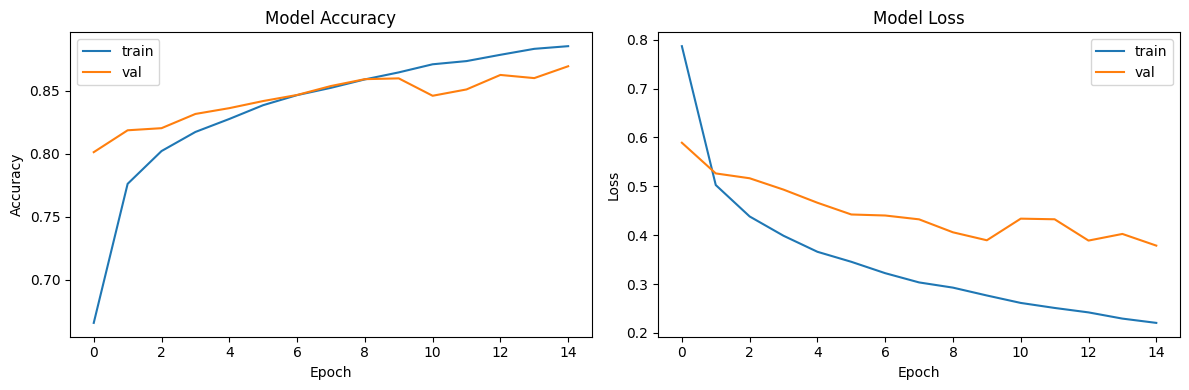

Eğitim grafikleri kaydedildi!


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('../reports/training_history.png')
plt.show()

print("Eğitim grafikleri kaydedildi!")
